In [2]:
!nvidia-smi

Thu Mar 25 15:58:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
# from scipy.misc import imresize
# from skimage.transform import rescale, resize, downscale_local_mean
from PIL import Image

import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import h5py
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model
import cv2

In [4]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import preprocess_input

import cv2
import os
import random
import collections
from collections import defaultdict

from shutil import copy
from shutil import copytree, rmtree

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

In [ ]:
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1])

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [5]:
root_position = "/content/drive/MyDrive/Colab Notebooks/Thesis/foodsClassification/"

In [ ]:
import os
all_files = os.listdir(root_position+"foods-IG/sushi/test")
nameList = []
for x in all_files:
  fileIn = os.listdir(root_position+"foods-IG/sushi/test/"+x)
  for i in fileIn:
    nameList.append(x+"/"+i)
print(nameList)
with open(root_position+"foods-IG/meta/test.txt", 'w') as f:
  for item in nameList:
    f.write("%s\n" % item)

['sushi/14350611_1745139269079269_871702448_n.jpg', 'sushi/14276600_544009492457779_677119291_n.jpg', 'sushi/14280560_642574385924270_455497691_n.jpg', 'sushi/14279127_535772216613459_1726605195_n.jpg', 'sushi/14334715_932588106885151_1159388922_n.jpg', 'sushi/14276674_336750743334438_5436922894401667072_n.jpg', 'sushi/14334301_191047494639132_5078918734416969728_n.jpg', 'sushi/14478458_1596122894023146_360501606157910016_n.jpg', 'sushi/14334728_169702833474087_3222105446374440960_n.jpg', 'sushi/14374252_1845361015696699_7070587956829880320_n.jpg', 'sushi/14359600_141943009597821_4026025678104166400_n.jpg', 'sushi/14533622_542790535928749_3413878566524289024_n.jpg', 'sushi/14504942_1114913061922276_2409802761332850688_n.jpg', 'sushi/14574227_708711179279954_4229519059630161920_n.jpg', 'sushi/14624252_949659311844707_960076498058870784_n.jpg', 'sushi/14592050_744559589028568_4715784824407719936_n.jpg', 'sushi/14474200_658117911014627_9131596003147776000_n.jpg', 'sushi/14693697_121465227

In [ ]:
class_to_ix = {}
ix_to_class = {}
with open(root_position+'foods-IG/meta/classes.txt', 'r') as txt:
  classes = [l.strip() for l in txt.readlines()]
  class_to_ix = dict(zip(classes, range(len(classes))))
  ix_to_class = dict(zip(range(len(classes)), classes))
  class_to_ix = {v: k for k, v in ix_to_class.items()}
sorted_class_to_ix = collections.OrderedDict(sorted(class_to_ix.items()))

# Only split files if haven't already
if not os.path.isdir(root_position+'foods-IG/sushi/test') and not os.path.isdir(root_position+'foods-IG/sushi/train'):

    def copytree(src, dst, symlinks = False, ignore = None):
        if not os.path.exists(dst):
            os.makedirs(dst)
            shutil.copystat(src, dst)
        lst = os.listdir(src)
        if ignore:
            excl = ignore(src, lst)
            lst = [x for x in lst if x not in excl]
        for item in lst:
            s = os.path.join(src, item)
            d = os.path.join(dst, item)
            if symlinks and os.path.islink(s):
                if os.path.lexists(d):
                    os.remove(d)
                os.symlink(os.readlink(s), d)
                try:
                    st = os.lstat(s)
                    mode = stat.S_IMODE(st.st_mode)
                    os.lchmod(d, mode)
                except:
                    pass # lchmod not available
            elif os.path.isdir(s):
                copytree(s, d, symlinks, ignore)
            else:
                shutil.copy2(s, d)

    def generate_dir_file_map(path):
        dir_files = defaultdict(list)
        with open(path, 'r') as txt:
            files = [l.strip() for l in txt.readlines()]
            for f in files:
                dir_name, id = f.split('/')
                dir_files[dir_name].append(id)
        return dir_files

    train_dir_files = generate_dir_file_map(root_position+'foods-IG/meta/train.txt')
    test_dir_files = generate_dir_file_map(root_position+'foods-IG/meta/test.txt')


    def ignore_train(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = train_dir_files[subdir]
        return to_ignore

    def ignore_test(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = test_dir_files[subdir]
        return to_ignore

    copytree(root_position+'foods-IG/images', root_position+'foods-IG/sushi/test', ignore=ignore_train)
    copytree(root_position+'foods-IG/images', root_position+'foods-IG/sushi/train', ignore=ignore_test)
    
else:
    print('Train/Test files already copied into separate folders.')

Train/Test files already copied into separate folders.


In [ ]:
print("Creating train data...")
prepare_data(root_position+'foods-IG/meta/train.txt', root_position+'foods-IG/images', root_position+'foods-IG/sushi/train')

Creating train data...
Copying Done!


In [ ]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data(root_position+'foods-IG/meta/test.txt', root_position+'foods-IG/images', root_position+'foods-IG/sushi/test')

Creating test data...

Copying images into  sushi


FileNotFoundError: ignored

In [ ]:
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [6]:
# picking 3 food items and generating separate data folders for the same
food_list = ['sushi','not']
src_train = root_position+'foods-IG/sushi/train'
dest_train = root_position+'foods-IG/sushi/train_mini'
src_test = root_position+'foods-IG/sushi/test'
dest_test = root_position+'foods-IG/sushi/test_mini'

In [ ]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes


NameError: ignored

In [7]:
print("Total number of samples in train folder")
train_files = sum([len(files) for i, j, files in os.walk(root_position+"foods-IG/sushi/train")])
print(train_files)

Total number of samples in train folder
1149


In [ ]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into sushi
Copying images into not


In [8]:
print("Total number of samples in test folder")
test_files = sum([len(files) for i, j, files in os.walk(root_position+"foods-IG/sushi/test")])
print(test_files)

Total number of samples in test folder
930


In [10]:
def train_model(n_classes,num_epochs, nb_train_samples,nb_validation_samples):
  K.clear_session()

  img_width, img_height = 299, 299
  train_data_dir = root_position+'foods-IG/sushi/train'
  validation_data_dir = root_position+'foods-IG/sushi/test'
  batch_size = 16
  bestmodel_path = '/content/drive/MyDrive/Colab Notebooks/Thesis/foodsClassification/foods-IG'+'weights-improvement-{epoch:02d}-{val_accuracy:.2f} bestmodel_2class.hdf5'
  trainedmodel_path = '/content/drive/MyDrive/Colab Notebooks/Thesis/foodsClassification/foods-IG'+'weights-improvement-{epoch:02d}-{val_accuracy:.2f} trainedmodel_2class.hdf5'
  history_path = '/content/drive/MyDrive/Colab Notebooks/Thesis/foodsClassification/foods-IG'+'history_'+str(n_classes)+'.log'

  train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')

  validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')


  inception = InceptionV3(weights='imagenet', include_top=False)
  x = inception.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(128,activation='relu')(x)
  x = Dropout(0.2)(x)

  predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

  model = Model(inputs=inception.input, outputs=predictions)
  model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
  checkpoint = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True, monitor='val_accuracy', mode='max')
  csv_logger = CSVLogger(history_path)

  history = model.fit_generator(train_generator,
                      steps_per_epoch = nb_train_samples // batch_size,
                      validation_data=validation_generator,
                      validation_steps=nb_validation_samples // batch_size,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=[csv_logger, checkpoint])

  model.save(trainedmodel_path)
  class_map = train_generator.class_indices
  return history, class_map

In [12]:
# Train the model with data from 3 classes
n_classes = 2
epochs = 50
nb_train_samples = train_files
nb_validation_samples = test_files

history, class_map_3 = train_model(n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_3)

Found 1149 images belonging to 2 classes.
Found 930 images belonging to 2 classes.
87916544/87910968 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
71/71 [==============================] - 1171s 16s/step - loss: 0.7067 - accuracy: 0.5837 - val_loss: 0.5441 - val_accuracy: 0.8211

Epoch 00001: val_accuracy improved from -inf to 0.82112, saving model to /content/drive/MyDrive/Colab Notebooks/Thesis/foodsClassification/foods-IGweights-improvement-01-0.82 bestmodel_2class.hdf5
Epoch 2/50
71/71 [==============================] - 55s 778ms/step - loss: 0.5320 - accuracy: 0.7737 - val_loss: 0.4137 - val_accuracy: 0.9041

Epoch 00002: val_accuracy improved from 0.82112 to 0.90409, saving model to /content/drive/MyDrive/Colab Notebooks/Thesis/foodsClassification/foods-IGweights-improvement-02-0.90 bestmodel_2class.hdf5
Epoch 3/50
71/71 [==============================] - 55s 774ms/step - loss: 0.4165 - accuracy: 0.8602 - val_loss: 0.3300 - val_accuracy: 0.9267

Epoch 00003: val_accuracy improved from 0.90409 to 0.92672, saving model to /content/drive/MyDrive/Colab Notebooks/Thesis/foodsClassification/foods-IGweights-improvement-0

In [ ]:
K.clear_session()
model_best = load_model('/content/drive/MyDrive/Colab Notebooks/Thesis/foodsClassification/trainedmodel_2class.hdf5',compile = False)

In [13]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img = preprocess_input(img)                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    #print(pred)
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


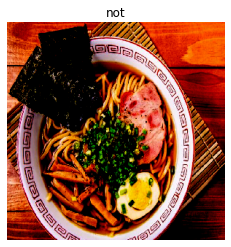

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


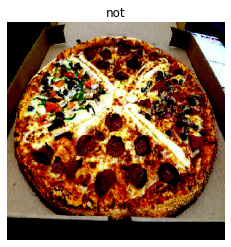

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


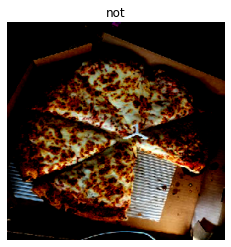

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


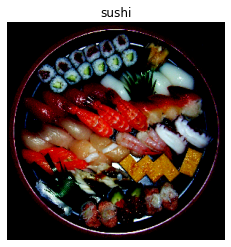

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


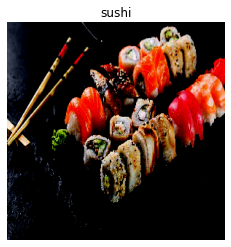

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


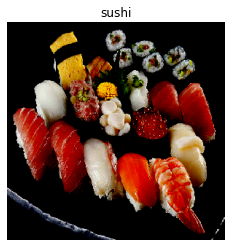

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


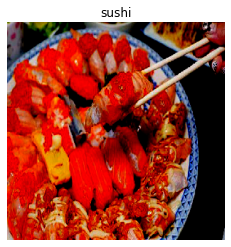

In [ ]:
# Make a list of images and test the trained model
images = []
imagepath = root_position+'food-101/try/'
images.append(imagepath+'ramen.jpg')
images.append(imagepath+'pizza.jpg')
images.append(imagepath+'pizza2.jpg')
images.append(imagepath+'sushi.jpg')
images.append(imagepath+'sushi2.jpg')
images.append(imagepath+'sushi3.jpg')
images.append(imagepath+'sushi4.jpg')
predict_class(model_best, images, True)

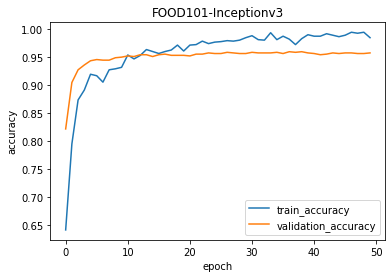

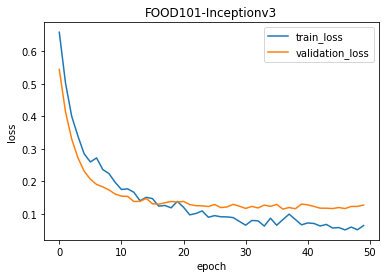

In [15]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

In [ ]:
def train_model_Next(n_classes,num_epochs, nb_train_samples,nb_validation_samples):
  K.clear_session()

  img_width, img_height = 299, 299
  train_data_dir = root_position+'foods-IG/sushi/train'
  validation_data_dir = root_position+'foods-IG/sushi/test'
  batch_size = 16
  bestmodel_path = '/content/drive/MyDrive/Colab Notebooks/Thesis/foodsClassification/Newbestmodel_2class.hdf5'
  trainedmodel_path = '/content/drive/MyDrive/Colab Notebooks/Thesis/foodsClassification/trainedmodel_2class.hdf5'
  history_path = '/content/drive/MyDrive/Colab Notebooks/Thesis/foodsClassification/history_2.log'

  train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')

  validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')


  # inception = InceptionV3(weights='imagenet', include_top=False)
  # x = inception.output
  # x = GlobalAveragePooling2D()(x)
  # x = Dense(128,activation='relu')(x)
  # x = Dropout(0.2)(x)

  # predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

  model = load_model('/content/drive/MyDrive/Colab Notebooks/Thesis/foodsClassification/bestmodel_2class.hdf5')
  model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
  checkpoint = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True, monitor='val_accuracy', mode='max')
  csv_logger = CSVLogger(history_path)

  history = model.fit_generator(train_generator,
                      steps_per_epoch = nb_train_samples // batch_size,
                      validation_data=validation_generator,
                      validation_steps=nb_validation_samples // batch_size,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=[csv_logger, checkpoint])

  # model.save(trainedmodel_path)
  class_map = train_generator.class_indices
  return history, class_map

In [ ]:
# Train the model with data from 3 classes
n_classes = 2
epochs = 10
nb_train_samples = train_files
nb_validation_samples = test_files

history, class_map_3 = train_model_Next(n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_3)

Found 1149 images belonging to 2 classes.
Found 930 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
71/71 [==============================] - 1300s 18s/step - loss: 0.1782 - accuracy: 0.9437 - val_loss: 0.1480 - val_accuracy: 0.9547

Epoch 00001: val_accuracy improved from -inf to 0.95474, saving model to /content/drive/MyDrive/Colab Notebooks/Thesis/foodsClassification/Newbestmodel_2class.hdf5
Epoch 2/10
71/71 [==============================] - 1218s 17s/step - loss: 0.1912 - accuracy: 0.9306 - val_loss: 0.1386 - val_accuracy: 0.9612

Epoch 00002: val_accuracy improved from 0.95474 to 0.96121, saving model to /content/drive/MyDrive/Colab Notebooks/Thesis/foodsClassification/Newbestmodel_2class.hdf5
Epoch 3/10
71/71 [==============================] - 1225s 17s/step - loss: 0.1455 - accuracy: 0.9638 - val_loss: 0.1399 - val_accuracy: 0.9547

Epoch 00003: val_accuracy did not improve from 0.96121
Epoch 4/10
71/71 [==============================] - 1227s 17s/step - loss: 0.1357 - accuracy: 0.9663 - val_loss: 0.1282 - val_accuracy: 0.9612

Epoch 00004: val_accuracy did not impr